In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neural_network import MLPClassifier
import sklearn.model_selection as ms

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

In [ ]:
df = pd.read_csv("nubank.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         44438 non-null  float64
 9   last_amount_borro

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: ignored

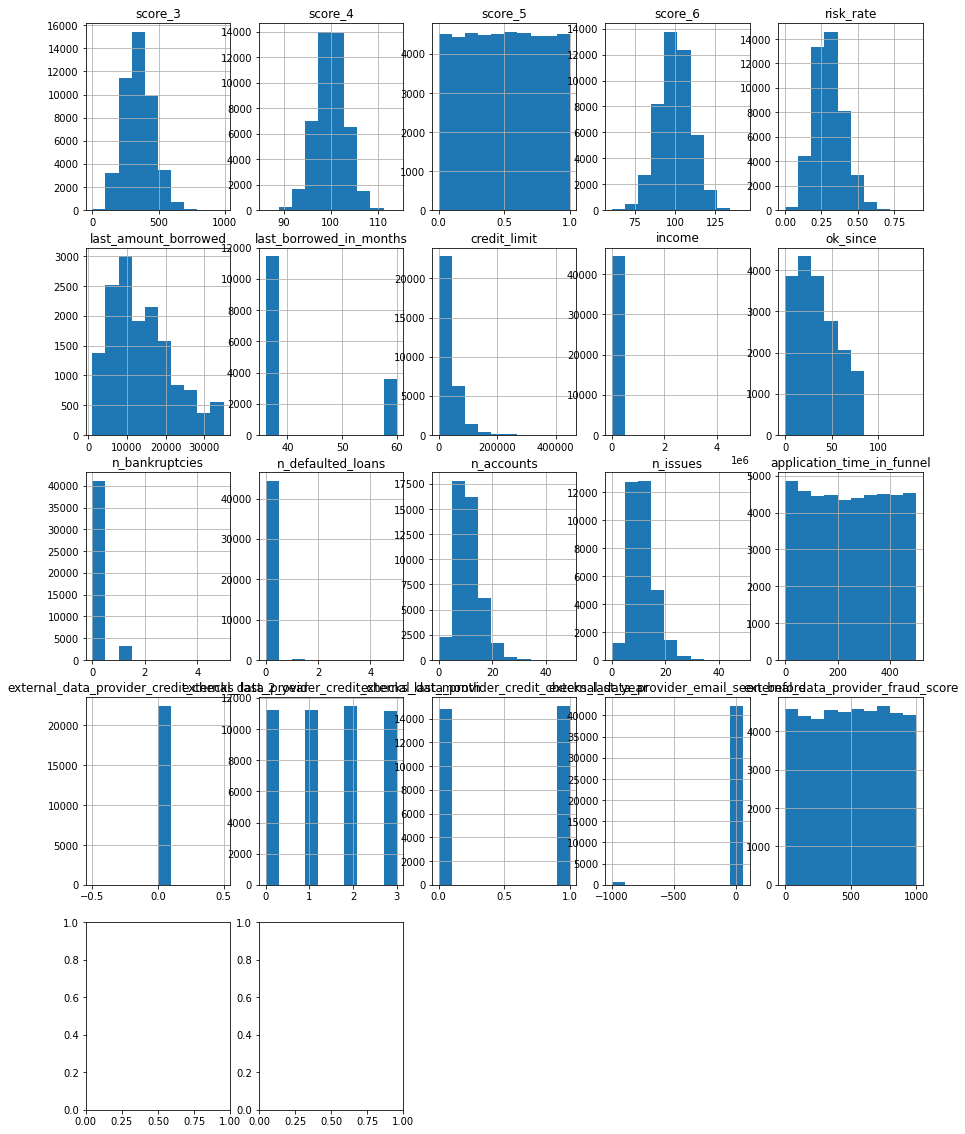

In [ ]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax=ax);

In [ ]:
# Valores Ausentes
print("\nValores Ausentes: ")
print((df.isnull().sum() / df.shape[0]).sort_values(ascending=False) * 100)


Valores Ausentes: 
target_fraud                                        96.617778
last_amount_borrowed                                66.568889
last_borrowed_in_months                             66.568889
ok_since                                            58.988889
external_data_provider_credit_checks_last_2_year    50.284444
external_data_provider_credit_checks_last_year      33.608889
credit_limit                                        30.666667
n_issues                                            25.653333
facebook_profile                                     9.906667
marketing_channel                                    7.951111
job_name                                             7.413333
target_default                                       7.242222
external_data_provider_email_seen_before             4.962222
lat_lon                                              3.028889
user_agent                                           1.604444
n_bankruptcies                                    

In [ ]:
# Valores Únicos

print("\nValores Únicos: ")
print(df.nunique().sort_values())


Valores Únicos: 
external_data_provider_credit_checks_last_2_year        1
channel                                                 1
target_fraud                                            2
target_default                                          2
external_data_provider_credit_checks_last_year          2
facebook_profile                                        2
last_borrowed_in_months                                 2
external_data_provider_credit_checks_last_month         4
n_defaulted_loans                                       5
real_state                                              5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                              

In [ ]:
#Copiando o dataset
df_tratado = df.copy()

#Exluindo os valores ausentes da variável alvo
df_tratado.dropna(subset = ['target_default'] ,inplace = True)

#Armazenando as variáveis a serem excluídas
Col_Ex = [
    'target_fraud',
    'last_amount_borrowed',
    'last_borrowed_in_months',
    'ok_since',
    'external_data_provider_credit_checks_last_2_year',
    'job_name',
    'external_data_provider_first_name',
    'profile_phone_number',
    'ids',
    'channel',
    'zip',
    'lat_lon',
    'shipping_zip_code',
    'reason',
    'user_agent', 
    'profile_tags',
    'application_time_applied',
    'email', 
    'marketing_channel',
    'facebook_profile',
    'application_time_applied'
    ]

#Exluindo as colunas do dataframe
df_tratado.drop(labels = Col_Ex, axis = 1, inplace = True)

#Substintuindo os valores negativos por NaN
df_tratado['external_data_provider_email_seen_before'] = df_tratado['external_data_provider_email_seen_before'].apply(lambda x: np.nan if x < 0 else x)
df_tratado['reported_income'] = df_tratado['reported_income'].apply(lambda x: np.nan if x == np.inf else x)

In [ ]:
feature_IQR = ['income',
               'reported_income',
               'n_accounts',
               'n_issues']

#Loop em relação as features
for feature in feature_IQR:

  Q1 = df_tratado[feature].quantile(q = 0.25) #Definindo o primeiro quartil
  Q3 = df_tratado[feature].quantile(q = 0.75) #Definindo o segundo quartil
  IQR = Q3 - Q1 #Definindo o interquartil
  Limite_Superior = Q3 + IQR #Definindo o Limite Superior
  Limite_Inferior = Q1 - IQR #Definindo o Limite Inferior

  #Eliminando os outliers acima do limite superior
  df_tratado.drop( df_tratado.loc[ df_tratado[feature] > Limite_Superior ].index, axis = 0, inplace = True )

  #Eliminando os outliers abaixo do limite inferior
  df_tratado.drop( df_tratado.loc[ df_tratado[feature] < Limite_Inferior ].index, axis = 0, inplace = True )


In [ ]:
dict_regiao = {'BR-RS' : 'Sul',
               'BR-RR': 'Norte',
               'BR-MT': 'Centro-Oeste',
               'BR-SP': 'Sudeste',
               'BR-AC': 'Norte',
               'BR-MS': 'Centro-Oeste',
               'BR-PE': 'Nordeste',
               'BR-AM': 'Norte',
               'BR-CE': 'Nordeste',
               'BR-AP': 'Norte',
               'BR-MA': 'Nosdeste',
               'BR-BA': 'Nordeste',
               'BR-TO': 'Norte',
               'BR-RO': 'Norte',
               'BR-GO': 'Centro-Oeste',
               'BR-SE': 'Nordeste',
               'BR-RN': 'Nordeste',
               'BR-MG': 'Sudeste',
               'BR-ES': 'Sudeste',
               'BR-PR': 'Sul',
               'BR-DF': 'Centro-Oeste',
               'BR-SC': 'Sul',
               'BR-PA': 'Norte',
               'BR-AL': 'Nordeste',
               'BR-PB': 'Nordeste'
               }

df_tratado['regiao'] = df_tratado['shipping_state'].apply(lambda x: dict_regiao[x])
df_tratado.drop(labels = ['shipping_state'], axis = 1, inplace = True)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


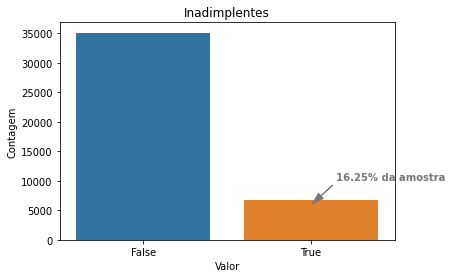

In [ ]:
# Relação entre Inadimplentes no Dataset
fig, ax = plt.subplots()
sns.countplot('target_default', data=df, ax=ax)
ax.set_title("Inadimplentes")
ax.set_xlabel("Valor")
ax.set_ylabel("Contagem")

percentual_default = round((df_tratado['target_default'].value_counts()[1] / df_tratado.shape[0])*100,2)

  #Criar uma informação no gráfico
ax.annotate(str(percentual_default) + "% da amostra",
  xy = (1, df_tratado['target_default'].value_counts()[1]),
  xytext = (25,25),
  color = "#787878",
  weight = 'bold',
  textcoords='offset points',
  arrowprops=dict(color = '#787878',  shrink= 0.05, width = 0.01, headwidth = 7))

plt.show()

In [ ]:
var_num = ['score_3',
           'score_4',
           'score_5',
           'score_6',
           'risk_rate',
           'credit_limit',
           'income',
           'n_bankruptcies',
           'n_defaulted_loans',
           'n_accounts',
           'n_issues',
           #'application_time_applied',
           'application_time_in_funnel',
           'external_data_provider_credit_checks_last_month',
           'external_data_provider_credit_checks_last_year',
           'external_data_provider_email_seen_before',
           'external_data_provider_fraud_score',
           'reported_income'
           ]
var_bin = ['target_default']
var_cat = ['score_1',
           'score_2',
           'state',
           'real_state',
           'regiao'
           ]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


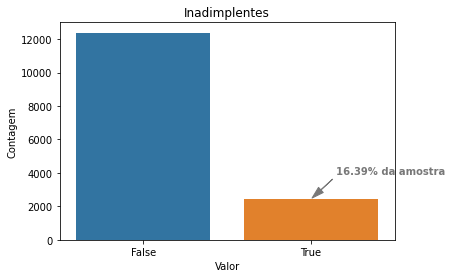

In [ ]:
#Vamos copiar o dataframe
df_trat = df_tratado.copy()
df_trat = df_trat.dropna()
#Instanciando o objeto labelEncoder
le = LabelEncoder()
# Relação entre Inadimplentes no Dataset
fig, ax = plt.subplots()
sns.countplot('target_default', data=df_trat, ax=ax)
ax.set_title("Inadimplentes")
ax.set_xlabel("Valor")
ax.set_ylabel("Contagem")

percentual_default = round((df_trat['target_default'].value_counts()[1] / df_trat.shape[0])*100,2)

  #Criar uma informação no gráfico
ax.annotate(str(percentual_default) + "% da amostra",
  xy = (1, df_trat['target_default'].value_counts()[1]),
  xytext = (25,25),
  color = "#787878",
  weight = 'bold',
  textcoords='offset points',
  arrowprops=dict(color = '#787878',  shrink= 0.05, width = 0.01, headwidth = 7))

plt.show()
#Criando um loop para codificar as variáveis binárias
for feature in var_bin:

  #transformando os valores binários em numéricos
  df_trat[feature] = le.fit_transform(df_trat[feature])

#Aplicando o get_dummies nas variáveis categóricas
df_trat = pd.get_dummies(data = df_trat, columns = var_cat)

In [ ]:
df_trat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14806 entries, 0 to 44997
Columns: 117 entries, target_default to regiao_Sul
dtypes: float64(14), int64(4), uint8(99)
memory usage: 3.5 MB


In [ ]:
#Definindo os valores de X e y
X = df_trat.drop(['target_default'], axis = 1)
y = df_trat['target_default']

#Dividindo o dataset em treino e test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    shuffle = True, 
                                                    stratify = y,
                                                    random_state = 42)

In [ ]:
#Instanciando o objeto RandomUnderSampler()
#rus = RandomUnderSampler(random_state = 0)

#Balanceando a amostra
#X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
oversample = SMOTE()
X_train_rus, y_train_rus = oversample.fit_resample(X_train, y_train)
#Transformando o array X em dataframe e y em série
X_train_rus = pd.DataFrame(X_train_rus, columns = X_train.columns)
y_train_rus = pd.Series(y_train_rus)

In [ ]:
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 42)
num_scaled = ColumnTransformer([("Padronizar", StandardScaler(), var_num)],
                         remainder='passthrough')

In [ ]:
model_rl = LogisticRegression(C = 1,
                              penalty = 'l2',
                              solver = 'liblinear',
                              random_state = 42)
'''#model_rl = LogisticRegression()

pipe = make_pipeline(num_scaled, model_rl)

score = cross_val_score(estimator = pipe,
                          X = X_train_rus,
                          y = y_train_rus,
                          scoring = 'roc_auc',
                          cv = k_fold)
print(score.mean())'''

"#model_rl = LogisticRegression()\n\npipe = make_pipeline(num_scaled, model_rl)\n\nscore = cross_val_score(estimator = pipe,\n                          X = X_train_rus,\n                          y = y_train_rus,\n                          scoring = 'roc_auc',\n                          cv = k_fold)\nprint(score.mean())"

In [ ]:
#Definindo os passos da pipeline
pipe = make_pipeline(num_scaled, LogisticRegression(random_state = 42))

#Definindo os parâmetros para simulação do GridSearch
param_grid = {"logisticregression__penalty": ['l1', 'l2', 'elasticnet', 'none'],
              "logisticregression__C": [100, 10, 1, 0, 0.1, 0.01],
              "logisticregression__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

#Instanciando o GridSearch
clf = GridSearchCV(estimator = pipe,
                   param_grid = param_grid,
                   scoring = 'roc_auc',
                   n_jobs = -1,
                   cv = k_fold)

#Ajustando com base no X_train e y_train balanceado
clf.fit(X = X_train_rus, 
        y = y_train_rus)

#Imprimindo o melhor parâmetro
clf.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
305 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  F

{'logisticregression__C': 1,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

In [ ]:
model_rl.fit(X_train_rus, y_train_rus)
y_previsto = model_rl.predict(X_test)
cm = confusion_matrix(y_test, y_previsto)

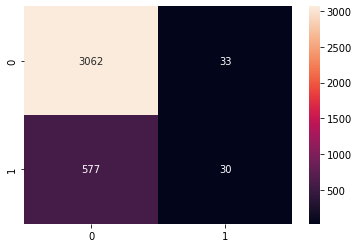

In [ ]:
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
acc = accuracy_score(y_test, y_previsto)
print(acc)
cr = classification_report(y_test, y_previsto, labels=[0,1])
print(cr)

0.8352242031334414
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3095
           1       0.48      0.05      0.09       607

    accuracy                           0.84      3702
   macro avg       0.66      0.52      0.50      3702
weighted avg       0.78      0.84      0.77      3702



Text(0, 0.5, 'True Positive Rate')

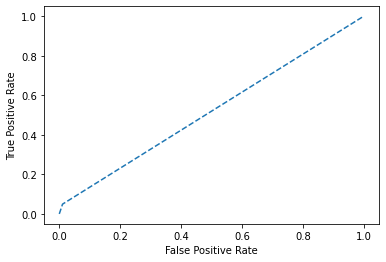

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

#%%
roc_fpr, roc_tpr, _ = roc_curve(y_test, y_previsto, pos_label=1)
plt.plot(roc_fpr, roc_tpr, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
clf = MLPClassifier(solver='sgd', hidden_layer_sizes=(20,10,4), learning_rate_init = 0.0025 , activation= 'tanh', max_iter=10000, random_state= 1
                    ,learning_rate = 'adaptive')
clf.fit(X_train_rus, y_train_rus)
y_predn = clf.predict_proba(X_test)
y_auxn = np.argmax(y_predn, 1)
accuracy_score(y_test, y_auxn)
acc = accuracy_score(y_test, y_auxn)
print(acc)

0.831172339276067


In [ ]:
#Curva Roc
roc_score = roc_auc_score(y_test, y_auxn)
print(roc_score)
cr = classification_report(y_test, y_auxn, labels=[0,1])
print(cr)

0.5037138074111137
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3095
           1       0.26      0.02      0.03       607

    accuracy                           0.83      3702
   macro avg       0.55      0.50      0.47      3702
weighted avg       0.74      0.83      0.76      3702



Text(0, 0.5, 'True Positive Rate')

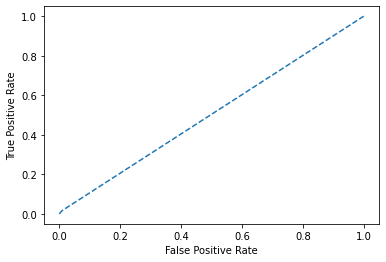

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

#%%
roc_fpr, roc_tpr, _ = roc_curve(y_test, y_auxn, pos_label=1)
plt.plot(roc_fpr, roc_tpr, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
pipe = make_pipeline(num_scaled, clf)

score = cross_val_score(estimator = pipe,
                          X = X_train_rus,
                          y = y_train_rus,
                          scoring = 'roc_auc',
                          cv = k_fold)
print(score.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.9347825320530573


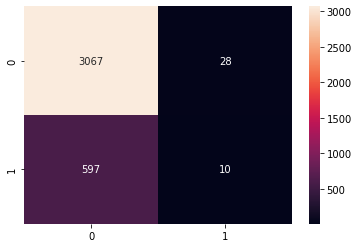

In [ ]:
cm = confusion_matrix(y_test, y_auxn)
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

mlpr = MLPRegressor(max_iter=1000)

param_list = {"hidden_layer_sizes": [(4,3), (3,2)], "activation": ["identity", "logistic", "tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005]}
gridCV = GridSearchCV(estimator=mlpr, param_grid=param_list)

splits = TimeSeriesSplit(n_splits=3)

gridCV.fit(X_train_rus, y_train_rus)
predicted = gridCV.predict(y_test)
parameters = mlpr.get_params()
test_mse = mean_squared_error(X_train_rus, predicted)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.7/dist-packages/sklearn/utils/e

KeyboardInterrupt: ignored